In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [3]:
root_audios_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_audios.csv"
root_recorders_Zamuro = f"{root}/Zamuro/Complementary_Files/zamuro_recorders.csv"
root_vggish_Zamuro = f"{root}/Zamuro/vggish/Features_vggish"

audios = pd.read_csv(root_audios_Zamuro, index_col=0)
recorders = pd.read_csv(root_recorders_Zamuro, index_col=0)

def combinar_nombre_ubicacion(row):
    return f"{row['field_number_PR']}_{row['Filename']}"

# Aplicando la función a cada fila del DataFrame para crear la nueva columna
audios['Filename_'] = audios.apply(combinar_nombre_ubicacion, axis=1)

audios.set_index("Filename_", inplace=True)

In [4]:
X_vgg = torch.load(f"{root_vggish_Zamuro}/vggish_features.pth")
y_vgg = torch.load(f"{root_vggish_Zamuro}/vggish_filenames.pth")
y_vgg = [i.split('/')[6:8] for i in y_vgg]
for i in range(len(y_vgg)):
    y_vgg[i] = f"{y_vgg[i][0]}_{y_vgg[i][1]}"

In [6]:
X_add = []
for i in range(len(X_vgg)):
    if(X_vgg[i].shape == torch.Size([62, 128])):
        X_add.append(i)
X_vgg2 = []
y_vgg2 = []
for i, value in enumerate(X_add):
    X_vgg2.append(X_vgg[value])
    y_vgg2.append(y_vgg[value])
X_vgg2 = torch.stack(X_vgg2)
X_vgg2 = X_vgg2.numpy()
X_vgg2 = X_vgg2.reshape(X_vgg2.shape[0], X_vgg2.shape[1]*X_vgg2.shape[2])

In [7]:
df_vgg = pd.DataFrame(X_vgg2)
df_vgg["y"] = y_vgg2
df_vgg
df_vgg.set_index("y", inplace=True, drop=False)
df_vgg['cover'] = df_vgg.index.map(audios['cover'])
df_vgg['rain_FI'] = df_vgg.index.map(audios['rain_FI'])

In [8]:
def extract_parts(row):
    parts = row.split('_')
    location = parts[0]
    date = parts[1]
    time = parts[2].split('.')[0]  # Eliminar la extensión .WAV
    day = date[-2:]  # Últimos dos caracteres para el día
    hour = time[:2]
    return pd.Series([location, day, hour])

# Aplicar la función a la columna 'y' y crear nuevas columnas
df_vgg[['location', 'day', 'hour']] =df_vgg['y'].apply(extract_parts)

def define_hour_stage(hour):
    hour = int(hour)
    if 5 <= hour <= 8:
        return 'morning'
    elif 9 <= hour <= 16:
        return 'day'
    else:
        return 'night'

df_vgg['hour_stage'] =df_vgg['hour'].apply(define_hour_stage)
df_vgg.set_index("y", inplace=True, drop=False)
df_vgg['cover'] = df_vgg.index.map(audios['cover'])
df_vgg = df_vgg[df_vgg['rain_FI'] == 'NO']

In [14]:
df_vgg.to_csv('df_vgg.csv', index=False) 
df_vgg = pd.read_csv("New_df_vgg.csv")
df_vgg.set_index("y", inplace=True)

## All classification covers

Accuracy: 0.6920694509619897
f1: 0.5666160664180073
recall 0.5487212688250795
[[0.06851244 0.09206945 0.03894885]
 [0.01163773 0.54265603 0.01773815]
 [0.03538245 0.11215392 0.08090099]]
[[ 730  981  415]
 [ 124 5782  189]
 [ 377 1195  862]]


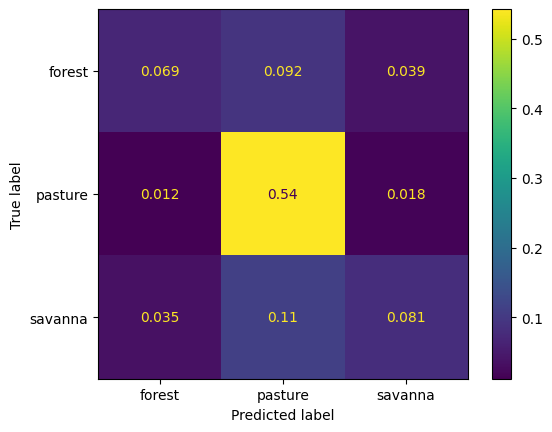

In [28]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


X = np.asarray(df_vgg.iloc[:,0:7936])
y = np.asarray(df_vgg.loc[:,"cover"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="all")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["forest", "pasture", "savanna"])
cm_display.plot()
plt.show()


## All classification Hours

Accuracy: 0.7632097606757391
f1: 0.6576930886446982
recall 0.6581342739762196
[[0.28718911 0.01679962 0.03256687]
 [0.07714688 0.04110746 0.04382919]
 [0.0531206  0.01332708 0.43491319]]
[[3060  179  347]
 [ 822  438  467]
 [ 566  142 4634]]


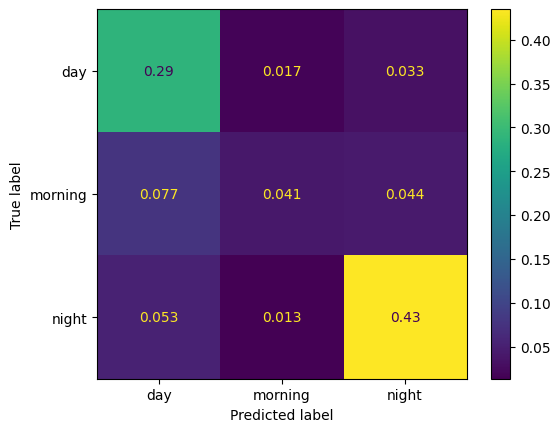

In [33]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


X = np.asarray(df_vgg.iloc[:,0:7936])
y = np.asarray(df_vgg.loc[:,"hour_stage"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="all")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["day", "morning", "night"])
cm_display.plot()
plt.show()


## Cover classification

In [30]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_vgg_covers = []
f1_scores_vgg_covers = []
recalls_vgg_covers = []
df_day={}
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_vgg[df_vgg['day'].isin([int(i)])]
    X = np.asarray(df_day.iloc[:,0:7936])
    y = np.asarray(df_day.loc[:,"cover"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_vgg_covers.append(accuracy)
    f1_scores_vgg_covers.append(f1_score)
    recalls_vgg_covers.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_vgg_covers.npy", accuracies_vgg_covers)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_vgg_covers.npy", f1_scores_vgg_covers)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_vgg_covers.npy", recalls_vgg_covers)

Accuracy: 0.7409638554216867
f1: 0.517826813907228
recall 0.49421921921921924
Accuracy: 0.7258261933904528
f1: 0.5352950434290147
recall 0.5094189639157664
Accuracy: 0.672911787665886
f1: 0.5423741084044416
recall 0.530647827996421
Accuracy: 0.6739876458476322
f1: 0.5577197731043885
recall 0.5448442348224868
Accuracy: 0.6973047684865239
f1: 0.5695047368781326
recall 0.5516767277853639
Accuracy: 0.6713286713286714
f1: 0.5334184929818446
recall 0.5184010691938522
Accuracy: 0.7314453125
f1: 0.6443469841817392
recall 0.6239249441692435
Accuracy: 0.7023255813953488
f1: 0.6073186102630636
recall 0.5901138199274846
Accuracy: 0.6823843416370107
f1: 0.5433396017992743
recall 0.526469136526882
Accuracy: 0.699724517906336
f1: 0.5143587617468215
recall 0.4968577339661677
Accuracy: 0.7695652173913043
f1: 0.6126932387869084
recall 0.5597807865892972


## Hour stage classification

In [11]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

accuracies_vgg_hours = []
f1_scores_vgg_hours = []
recalls_vgg_hours = []
df_day={}
for i in ["03","04","05","06","07","08","09","10","11","12","13"]:
    df_day = df_vgg[df_vgg['day'].isin([i])]
    X = np.asarray(df_day.loc[:,0:7935])
    y = np.asarray(df_day.loc[:,"hour_stage"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_vgg_hours.append(accuracy)
    f1_scores_vgg_hours.append(f1_score)
    recalls_vgg_hours.append(recall)
    
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/accuracies_vgg_hours.npy", accuracies_vgg_hours)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/f1_scores_vgg_hours.npy", f1_scores_vgg_hours)
np.save(f"{root}/Zamuro/temporal_zamuro/zamuro_classification_results/recalls_vgg_hours.npy", recalls_vgg_hours)

Accuracy: 0.8744588744588745
f1: 0.544538504951003
recall 0.5466715794645051
Accuracy: 0.8043694141012909
f1: 0.6801789829725702
recall 0.6636315440689199
Accuracy: 0.7925973197192087
f1: 0.685916507724201
recall 0.6796180111550197
Accuracy: 0.8091954022988506
f1: 0.744113094338467
recall 0.7379110407412295
Accuracy: 0.8302752293577982
f1: 0.7576789393014014
recall 0.7532690485835275
Accuracy: 0.7560025957170668
f1: 0.7062505941711029
recall 0.703047714069536
Accuracy: 0.7723177723177723
f1: 0.6099180676509789
recall 0.6041618468807569
Accuracy: 0.7513069454817027
f1: 0.5654124336623073
recall 0.5819439475253428
Accuracy: 0.7885174418604651
f1: 0.7115831865320104
recall 0.7050334006236699
Accuracy: 0.7851428571428571
f1: 0.7525824343343852
recall 0.761300908522797
Accuracy: 0.7878787878787878
f1: 0.7345715037449958
recall 0.719786505032825
